In [1]:
!nvidia-smi

Thu Oct 10 07:22:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
! pip install plotly -q

In [3]:
!git clone https://github.com/openai/point-e

Cloning into 'point-e'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 57 (delta 1), reused 1 (delta 1), pack-reused 50 (from 1)
Receiving objects: 100% (57/57), 1.56 MiB | 3.59 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [4]:
%cd point-e

/content/point-e


In [5]:
! pip install -e .

Obtaining file:///content/point-e
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-install-cnelgn1h/clip_5ee6786874aa45358adf3938ea7b7d28
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-install-cnelgn1h/clip_5ee6786874aa45358adf3938ea7b7d28
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.0/43.0 kB 3.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369490 sha256=0b78ee96de9a0ea98ac3e4bd0d32976a93812e05c075d9c21e408a2bbf595094
  Stored in directory: /tmp/pip-ephem-wheel-cache-l9u3kd_9/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
  Created wheel for fire: filename=fire-0.7.0-py3-

In [6]:
import torch
from tqdm.auto import tqdm

from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...


100%|███████████████████████████████████████| 890M/890M [00:13<00:00, 66.7MiB/s]


creating upsample model...
downloading base checkpoint...


  0%|          | 0.00/161M [00:00<?, ?iB/s]

/content/point-e/point_e/models/download.py:78: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(path, map_location=device)


downloading upsampler checkpoint...


  0%|          | 0.00/162M [00:00<?, ?iB/s]

<All keys matched successfully>

In [8]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

In [57]:
# Set a prompt to condition on.
prompt = 'a calm ocean with rolling waves and a clear horizon'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

In [58]:
pc = sampler.output_to_point_clouds(samples)[0]

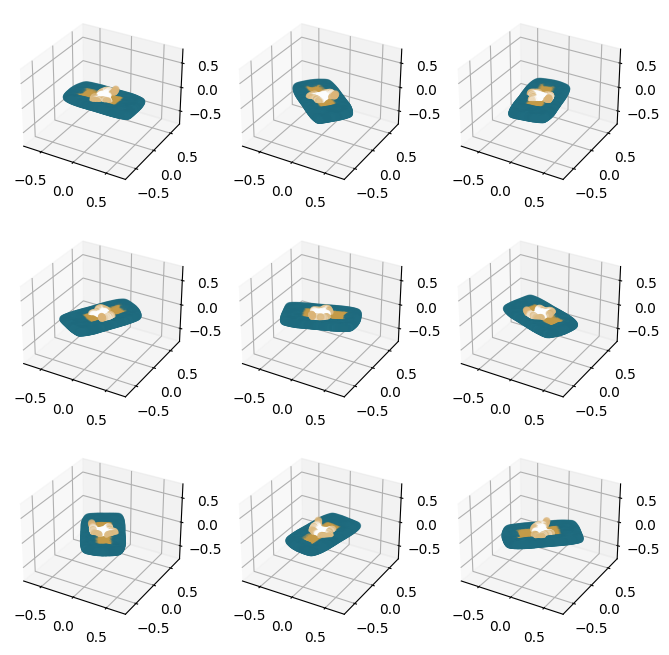

In [59]:
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

In [60]:
import plotly.graph_objects as go


In [61]:
fig_plotly = go.Figure(
        data=[
            go.Scatter3d(
                x=pc.coords[:,0], y=pc.coords[:,1], z=pc.coords[:,2],
                mode='markers',
                marker=dict(
                  size=2,
                  color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(pc.channels["R"], pc.channels["G"], pc.channels["B"])],
              )
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False)
            )
        ),
    )

In [62]:
fig_plotly.show(renderer="colab")


In [63]:
from point_e.util.pc_to_mesh import marching_cubes_mesh

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating SDF model...')
name = 'sdf'
model = model_from_config(MODEL_CONFIGS[name], device)
model.eval()

print('loading SDF model...')
model.load_state_dict(load_checkpoint(name, device))

creating SDF model...
loading SDF model...


<All keys matched successfully>

In [65]:
import skimage.measure as measure

In [66]:
# Produce a mesh (with vertex colors)
mesh = marching_cubes_mesh(
    pc=pc,
    model=model,
    batch_size=4096,
    grid_size=32, # increase to 128 for resolution used in evals
    progress=True,
)

  0%|          | 0/8 [00:00<?, ?it/s]

In [67]:
# Write the mesh to a PLY file to import into some other program.
with open('ocean_prompt_1.ply', 'wb') as f:
    mesh.write_ply(f)

In [68]:
from google.colab import files
files.download('ocean_prompt_1.ply')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>